In [214]:
import numpy as np
import pandas as pd
import re
from sklearn.metrics import confusion_matrix, f1_score, roc_auc_score, accuracy_score, roc_curve, silhouette_score
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.layers import Input
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from lime.lime_text import LimeTextExplainer
import nltk
from nltk.corpus import stopwords
from textblob import TextBlob
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
import seaborn as sns
import emoji
from textblob import TextBlob
import time
from sklearn.cluster import KMeans
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
from lime.lime_text import LimeTextExplainer
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

In [215]:
# Load CSV data
data = pd.read_csv("C:/Users/Dell/OneDrive/Desktop/sem 3/NLP/ass-4/Sentiment_Data.csv",encoding='ISO-8859-1',nrows=30000)  # Ensure your CSV has 'Sentiment', 'Count', 'text', and 'label' columns

In [216]:
data.head()

Tweet Sentiment
0  @_angelica_toy Happy Anniversary!!!....The Day...  Mild_Pos
1  @McfarlaneGlenda Happy Anniversary!!!....The D...  Mild_Pos
2  @thevivafrei @JustinTrudeau Happy Anniversary!...  Mild_Pos
3  @NChartierET Happy Anniversary!!!....The Day t...  Mild_Pos
4  @tabithapeters05 Happy Anniversary!!!....The D...  Mild_Pos

In [217]:
data.shape

(30000, 2)

In [218]:
# Sentiment Mapping
sentiment_mapping = {
    'Strong_Pos': 'Positive',
    'Mild_Pos': 'Positive',
    'Strong_Neg': 'Negative',
    'Mild_Neg': 'Negative',
    'Neutral': 'Neutral'
}

In [219]:
data['Simplified_Sentiment'] = data['Sentiment'].map(sentiment_mapping)

In [220]:
# Fill missing values in 'Tweet' column with an empty string to avoid errors
data['Tweet'] = data['Tweet'].fillna('')

In [221]:
# Ensure NLTK resources are downloaded
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [222]:
# Initialize lemmatizer and stop words
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

In [223]:
# Extended contraction dictionary
contractions = {
    "can't": "cannot", "won't": "will not", "n't": " not", "'re": " are", "'s": " is", "'d": " would",
    "'ll": " will", "'t": " not", "'ve": " have", "'m": " am", "i'm": "i am", "you're": "you are",
    "we're": "we are", "they're": "they are", "it's": "it is", "that's": "that is", "there's": "there is"
}

In [224]:
def clean_text(text):
    # 1. Remove URLs
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
    # 2. Remove mentions and hashtags
    text = re.sub(r'\@\w+|\#', '', text)
    # 3. Handle contractions
    for contraction, expanded in contractions.items():
        text = re.sub(r"\b{}\b".format(re.escape(contraction)), expanded, text)
    # 6. Remove punctuation and special characters
    text = re.sub(r'[^A-Za-z0-9\s]', '', text)
    # 7. Correct spelling
    # text = str(TextBlob(text).correct())
    # 8. Tokenize text and remove stop words
    words = text.split()
    words = [word for word in words if word.lower() not in stop_words]
    # 9. Lemmatize words
    words = [lemmatizer.lemmatize(word) for word in words]
    # 10. Convert to lowercase
    text = ' '.join(words).lower()

    return text

In [225]:
data['cleaned_text'] = data['Tweet'].apply(clean_text)

In [226]:
# Emoji Handling
def handle_emoji(text):
    return emoji.demojize(text, delimiters=(" ", " "))

In [227]:
data['emoji_handled_text'] = data['cleaned_text'].apply(handle_emoji)

In [228]:
slang_dict = {
    'afaik': 'as far as I know',
    'b4': 'before',
    'b/c': 'because',
    'brb': 'be right back',
    'btw': 'by the way',
    'cya': 'see you',
    'dm': 'direct message',
    'fomo': 'fear of missing out',
    'ftw': 'for the win',
    'fyi': 'for your information',
    'gr8': 'great',
    'gtg': 'got to go',
    'hbu': 'how about you',
    'hmu': 'hit me up',
    'idc': 'I don’t care',
    'idk': "I don't know",
    'ikr': 'I know right',
    'imo': 'in my opinion',
    'imho': 'in my humble opinion',
    'irl': 'in real life',
    'jk': 'just kidding',
    'l8r': 'later',
    'lmao': 'laughing my ass off',
    'lmfao': 'laughing my f***ing ass off',
    'lol': 'laughing out loud',
    'msg': 'message',
    'np': 'no problem',
    'nvm': 'never mind',
    'omg': 'oh my god',
    'omw': 'on my way',
    'pls': 'please',
    'plz': 'please',
    'rofl': 'rolling on the floor laughing',
    'smh': 'shaking my head',
    'tbh': 'to be honest',
    'tbt': 'throwback Thursday',
    'ttyl': 'talk to you later',
    'u': 'you',
    'ur': 'your',
    'w/e': 'whatever',
    'w/o': 'without',
    'wbu': 'what about you',
    'wyd': 'what you doing',
    'wtf': 'what the f***',
    'yolo': 'you only live once',
    'y/w': 'you’re welcome',
    'yt': 'YouTube',
    'bff': 'best friend forever',
    'gonna': 'going to',
    'gotta': 'got to',
    'wanna': 'want to',
    'luv': 'love',
    'tho': 'though',
    'abt': 'about',
    '2day': 'today',
    '2moro': 'tomorrow',
    '2nite': 'tonight',
    'pic': 'picture',
    'ppl': 'people',
    'thx': 'thanks',
    'grats': 'congratulations',
    'gr8': 'great',
    'jk': 'just kidding',
    'fam': 'family or close friends',
    'bruh': 'brother or dude',
    'sus': 'suspicious',
    'lit': 'exciting or excellent',
    'savage': 'bold or aggressive',
    'bae': 'before anyone else (significant other)',
    'dope': 'cool or impressive',
    'fomo': 'fear of missing out',
    'fam': 'family or friends',
    'shade': 'disrespect or criticism',
    'stan': 'an extremely devoted fan',
    'snatched': 'looks good or on point',
    'thirsty': 'desperate or attention-seeking'
}

In [229]:
abbreviations_dict = {
    'afaik': 'as far as I know',
    'b/c': 'because',
    'b4': 'before',
    'bff': 'best friend forever',
    'brb': 'be right back',
    'btw': 'by the way',
    'cya': 'see you',
    'dm': 'direct message',
    'fb': 'Facebook',
    'fomo': 'fear of missing out',
    'ftw': 'for the win',
    'fyi': 'for your information',
    'g2g': 'got to go',
    'gg': 'good game',
    'hmu': 'hit me up',
    'idc': "I don't care",
    'idk': "I don't know",
    'ikr': 'I know right',
    'ily': 'I love you',
    'imo': 'in my opinion',
    'imho': 'in my humble opinion',
    'irl': 'in real life',
    'jk': 'just kidding',
    'l8r': 'later',
    'lmk': 'let me know',
    'lmao': 'laughing my ass off',
    'lmfao': 'laughing my freaking ass off',
    'lol': 'laughing out loud',
    'msg': 'message',
    'nbd': 'no big deal',
    'np': 'no problem',
    'nvm': 'never mind',
    'omg': 'oh my god',
    'omw': 'on my way',
    'pls': 'please',
    'plz': 'please',
    'rofl': 'rolling on the floor laughing',
    'smh': 'shaking my head',
    'tbh': 'to be honest',
    'tbt': 'throwback Thursday',
    'ttyl': 'talk to you later',
    'u': 'you',
    'ur': 'your',
    'w/e': 'whatever',
    'w/o': 'without',
    'wbu': 'what about you',
    'wyd': 'what you doing',
    'wtf': 'what the freak',
    'yolo': 'you only live once',
    'yw': "you're welcome",
    'yt': 'YouTube',
    'asap': 'as soon as possible',
    'bday': 'birthday',
    'bc': 'because',
    'cuz': 'because',
    'fam': 'family',
    'fb': 'Facebook',
    'gf': 'girlfriend',
    'bf': 'boyfriend',
    'gr8': 'great',
    'imo': 'in my opinion',
    'imho': 'in my humble opinion',
    'irl': 'in real life',
    'jk': 'just kidding',
    'np': 'no problem',
    'nvm': 'never mind',
    'omw': 'on my way',
    'r': 'are',
    'ttyl': 'talk to you later',
    'wanna': 'want to',
    'gonna': 'going to',
    'gotta': 'got to',
    'thx': 'thanks',
    'thnx': 'thanks',
    'bffl': 'best friend for life',
    'ily': 'I love you',
    'atm': 'at the moment',
    'bruh': 'brother',
    'b4n': 'bye for now',
    'bb': 'bye bye',
    'bt': 'but',
    'btwn': 'between',
    'cu': 'see you',
    'ez': 'easy',
    'gratz': 'congratulations',
    'gr8': 'great',
    'hbd': 'happy birthday',
    'imo': 'in my opinion',
    'imma': "I'm going to",
    'j/k': 'just kidding',
    'k': 'okay',
    'lil': 'little',
    'ltns': 'long time no see',
    'm8': 'mate',
    'msg': 'message',
    'mssg': 'message',
    'n1': 'nice one',
    'nc': 'no comment',
    'noob': 'newbie',
    'nm': 'not much',
    'omg': 'oh my god',
    'otw': 'on the way',
    'ppl': 'people',
    'rly': 'really',
    'sup': 'what’s up',
    'tldr': 'too long didn’t read',
    'txt': 'text',
    'wth': 'what the heck',
    'xoxo': 'hugs and kisses',
    'y': 'why',
    'yeet': 'throw with force',
    'zzz': 'sleepy or bored'
}

In [230]:
def handle_slang_and_abbr(text):
    words = text.split()
    words = [slang_dict.get(word.lower(), abbreviations_dict.get(word.lower(), word)) for word in words]
    return ' '.join(words)

In [231]:
data['slang_abbr_handled_text'] = data['emoji_handled_text'].apply(handle_slang_and_abbr)

In [232]:
# A dictionary of antonyms for handling common negations
antonym_dict = {
    'good': 'bad',
    'happy': 'sad',
    'easy': 'difficult',
    'interesting': 'boring',
    'smart': 'dull',
    'like': 'dislike',
    'love': 'hate',
    'success': 'failure',
    'strong': 'weak',
    'possible': 'impossible',
    'safe': 'dangerous'
}

In [233]:
def handle_negation(text):
    # Pattern to match phrases like "not good", "never easy", "no love"
    negation_pattern = r'\b(not|never|no)\s+(\w+)\b'
    
    def replace_with_antonym(match):
        negation, word = match.groups()
        # Replace with antonym if available; otherwise, keep the original phrase
        return antonym_dict.get(word, f"{negation} {word}")
    
    # Substitute negated phrases with their antonyms if available
    text = re.sub(negation_pattern, replace_with_antonym, text)
    
    return text

In [234]:
data['processed_text'] = data['slang_abbr_handled_text'].apply(handle_negation)

In [235]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [236]:
# Initialize VADER sentiment analyzer
sia = SentimentIntensityAnalyzer()

def get_sentiment_vader(text):
    sentiment_scores = sia.polarity_scores(text)
    polarity = sentiment_scores['compound']  # Overall polarity from -1 to 1
    subjectivity = abs(sentiment_scores['pos'] - sentiment_scores['neg'])  # Approximate subjectivity
    return polarity, subjectivity

In [237]:
# Assuming `data` is your DataFrame with a column 'processed_text'
data[['polarity', 'subjectivity']] = data['processed_text'].apply(lambda x: pd.Series(get_sentiment_vader(x)))

In [238]:
# Encode target variable (assuming 'Positive', 'Neutral', 'Negative')
label_mapping = {'Positive': 2, 'Neutral': 1, 'Negative': 0}
data['encoded_label'] = data['Simplified_Sentiment'].map(label_mapping)

In [239]:
# Perform train-test split directly on the DataFrame while ensuring >5000 samples in the test set
train_data, test_data = train_test_split(data, test_size=0.20, random_state=42)

In [240]:
# Verify test set size
print("Test set size:", len(test_data))
assert len(test_data) > 4000, "Test set must have more than 5000 samples."

Test set size: 6000


In [241]:
# Apply sentiment feature engineering only after splitting
train_data[['polarity', 'subjectivity']] = train_data['processed_text'].apply(lambda x: pd.Series(get_sentiment_vader(x)))
test_data[['polarity', 'subjectivity']] = test_data['processed_text'].apply(lambda x: pd.Series(get_sentiment_vader(x)))

In [242]:
# Extract text and label columns for training and testing
X_train_text = train_data['processed_text'].values
X_test_text = test_data['processed_text'].values
y_train = train_data['encoded_label'].values
y_test = test_data['encoded_label'].values

In [243]:
# Extract the sentiment features for scaling and PCA
train_sentiment = train_data[['polarity', 'subjectivity']]
test_sentiment = test_data[['polarity', 'subjectivity']]

In [244]:
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train_text)  # Fit tokenizer on training data only
sequences = tokenizer.texts_to_sequences(X_train_text)

# Calculate 90th percentile length for padding
lengths = [len(seq) for seq in sequences]
max_length = int(np.percentile(lengths, 90))  # Set max length as the 90th percentile
print("Chosen max_length:", max_length)

Chosen max_length: 24


In [245]:
X_train_padded = pad_sequences(tokenizer.texts_to_sequences(X_train_text), maxlen=100, padding='post')
X_test_padded = pad_sequences(tokenizer.texts_to_sequences(X_test_text), maxlen=100, padding='post')

In [246]:
# Scaling and PCA on sentiment features
scaler = StandardScaler()
train_sentiment_scaled = scaler.fit_transform(train_sentiment)  # Fit on training data only
test_sentiment_scaled = scaler.transform(test_sentiment)        # Transform test data with the same scaler

pca = PCA(n_components=2)
train_sentiment_pca = pca.fit_transform(train_sentiment_scaled)  # Fit PCA on training data only
test_sentiment_pca = pca.transform(test_sentiment_scaled)        # Transform test data with the same PCA

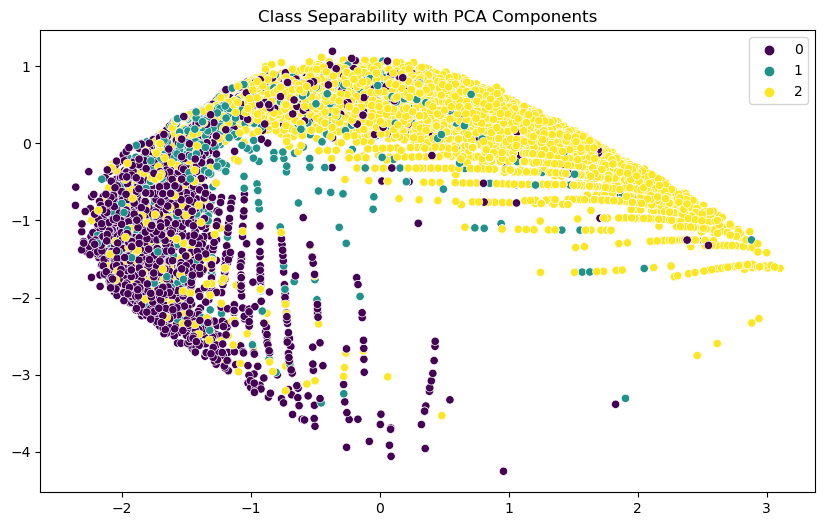

In [247]:
# Create a copy of the sentiment data from the training subset to avoid SettingWithCopyWarning
train_sentiment = train_data[['polarity', 'subjectivity']].copy()
test_sentiment = test_data[['polarity', 'subjectivity']].copy()

# Encode the target variable for class separability check
label_encoder = LabelEncoder()
train_sentiment['target_encoded'] = label_encoder.fit_transform(y_train)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=train_sentiment_pca[:, 0], y=train_sentiment_pca[:, 1], hue=y_train, palette='viridis')
plt.title("Class Separability with PCA Components")
plt.show()

In [248]:
# Calculate silhouette score after performing KMeans clustering
kmeans = KMeans(n_clusters=len(np.unique(y_train)), random_state=42)

# Explicitly assign cluster labels with .loc to avoid the warning
train_sentiment.loc[:, 'cluster_labels'] = kmeans.fit_predict(train_sentiment[['polarity', 'subjectivity']])

# Calculate the silhouette score
silhouette_avg = silhouette_score(train_sentiment[['polarity', 'subjectivity']], train_sentiment['cluster_labels'])
print(f"Silhouette Score for 'polarity' and 'subjectivity': {silhouette_avg}")


Silhouette Score for 'polarity' and 'subjectivity': 0.46365527317375316


In [249]:
# Bidirectional LSTM Model for 3-class classification
embedding_dim = 128
lstm_units = 64
dropout_rate = 0.5
vocab_size = 20000

In [250]:
model = Sequential([
    Input(shape=(max_length,)),  # Define input shape in a separate Input layer
    Embedding(vocab_size, embedding_dim),
    Bidirectional(LSTM(lstm_units, return_sequences=True)),
    Dropout(dropout_rate),
    Bidirectional(LSTM(lstm_units)),
    Dense(3, activation='softmax')  # 3 output units for Positive, Neutral, and Negative
])

In [251]:
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_7 (Embedding)              │ (None, 24, 128)             │       2,560,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_12 (Bidirectional)     │ (None, 24, 128)             │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 24, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_13 (Bidirectional)     │ (None, 128)                 │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,758,019 (10.52 MB)

 Trainable params: 2,758,019 (10.52 MB)

 Non-trainable params: 0 (0.00 B)

In [252]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [253]:
# Model Training and Evaluation
start_time = time.time()
history = model.fit(X_train_padded, y_train, epochs=10, batch_size=32, validation_data=(X_test_padded, y_test), verbose=1)

Epoch 1/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 93s 117ms/step - accuracy: 0.7309 - loss: 0.7148 - val_accuracy: 0.8008 - val_loss: 0.5466
Epoch 2/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 92s 122ms/step - accuracy: 0.8537 - loss: 0.4168 - val_accuracy: 0.8008 - val_loss: 0.5341
Epoch 3/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 89s 118ms/step - accuracy: 0.8913 - loss: 0.3108 - val_accuracy: 0.7870 - val_loss: 0.6318
Epoch 4/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 93s 124ms/step - accuracy: 0.9192 - loss: 0.2393 - val_accuracy: 0.7838 - val_loss: 0.6370
Epoch 5/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 97s 129ms/step - accuracy: 0.9387 - loss: 0.1860 - val_accuracy: 0.7847 - val_loss: 0.7834
Epoch 6/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 92s 123ms/step - accuracy: 0.9549 - loss: 0.1367 - val_accuracy: 0.7772 - val_loss: 0.8384
Epoch 7/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 89s 119ms/step - accuracy: 0.9639 - loss: 0.1080 - val_accuracy: 0.7747 - val_loss: 0.9464
Epoch 8/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 90s 120ms/step - accuracy: 0.9677 - loss: 0

In [254]:
train_time = time.time() - start_time
print(f"Training Time: {train_time:.2f} seconds")
train_time_minutes = train_time / 60
print(f"Training Time: {train_time_minutes:.2f} minutes")

Training Time: 946.03 seconds
Training Time: 15.77 minutes


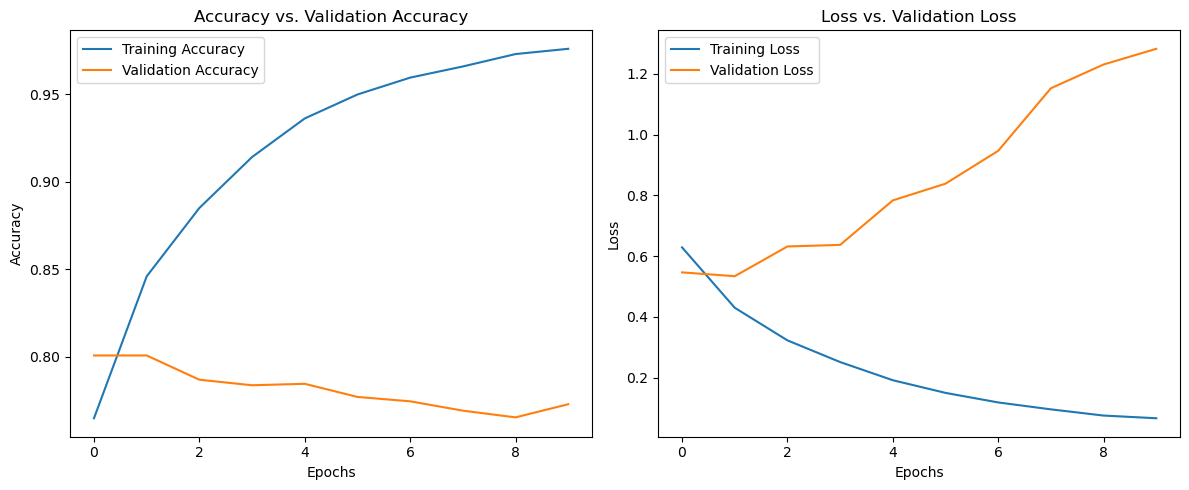

In [255]:
# Plot Accuracy vs. Validation Accuracy
plt.figure(figsize=(12, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Validation Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs. Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [256]:
# Evaluate on Training Data
y_train_pred_prob = model.predict(X_train_padded)
y_train_pred = np.argmax(y_train_pred_prob, axis=1)
train_conf_matrix = confusion_matrix(y_train, y_train_pred)
f1_train = f1_score(y_train, y_train_pred, average=None, labels=[2, 1, 0])  # F1 scores for Positive, Neutral, Negative
train_auc = roc_auc_score(pd.get_dummies(y_train), y_train_pred_prob, average='macro', multi_class='ovo')
train_accuracy = accuracy_score(y_train, y_train_pred)

750/750 ━━━━━━━━━━━━━━━━━━━━ 37s 48ms/step


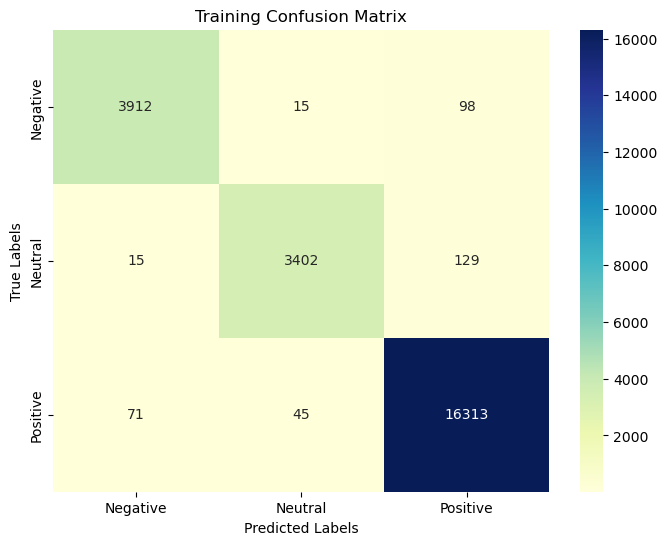

In [257]:
# Calculate the confusion matrix for the training set
train_conf_matrix = confusion_matrix(y_train, y_train_pred)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(train_conf_matrix, annot=True, fmt='d', cmap='YlGnBu', cbar=True, 
            xticklabels=["Negative", "Neutral", "Positive"], 
            yticklabels=["Negative", "Neutral", "Positive"])

plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Training Confusion Matrix")
plt.show()

In [258]:
# Evaluate on Testing Data
y_test_pred_prob = model.predict(X_test_padded)
y_test_pred = np.argmax(y_test_pred_prob, axis=1)
test_conf_matrix = confusion_matrix(y_test, y_test_pred)
f1_test = f1_score(y_test, y_test_pred, average=None, labels=[2, 1, 0])  # F1 scores for Positive, Neutral, Negative
test_auc = roc_auc_score(pd.get_dummies(y_test), y_test_pred_prob, average='macro', multi_class='ovo')
test_accuracy = accuracy_score(y_test, y_test_pred)

188/188 ━━━━━━━━━━━━━━━━━━━━ 13s 70ms/step


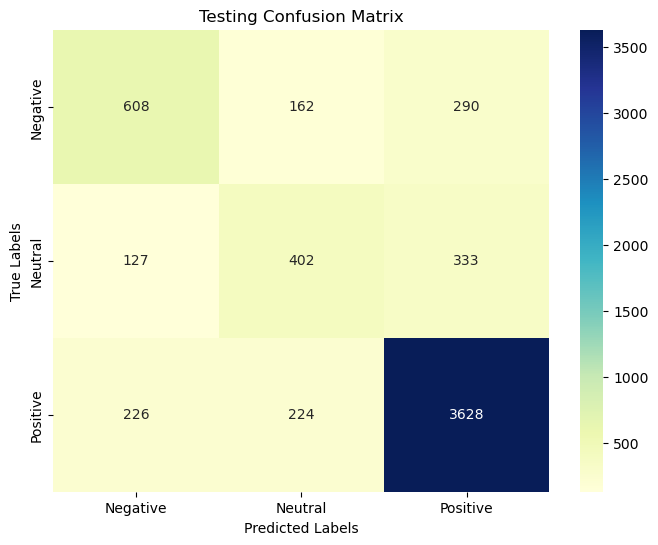

In [259]:
# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)

# Plot the confusion matrix as a heatmap with colors
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='YlGnBu', cbar=True, 
            xticklabels=["Negative", "Neutral", "Positive"], 
            yticklabels=["Negative", "Neutral", "Positive"])

plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Testing Confusion Matrix")
plt.show()

In [260]:
from sklearn.metrics import classification_report

# Training Data Classification Report
print("Training Classification Report:")
print(classification_report(y_train, y_train_pred, target_names=["Negative", "Neutral", "Positive"]))

Training Classification Report:
              precision    recall  f1-score   support

    Negative       0.98      0.97      0.98      4025
     Neutral       0.98      0.96      0.97      3546
    Positive       0.99      0.99      0.99     16429

    accuracy                           0.98     24000
   macro avg       0.98      0.97      0.98     24000
weighted avg       0.98      0.98      0.98     24000



In [261]:
# Testing Data Classification Report
print("\nTesting Classification Report:")
print(classification_report(y_test, y_test_pred, target_names=["Negative", "Neutral", "Positive"]))



Testing Classification Report:
              precision    recall  f1-score   support

    Negative       0.63      0.57      0.60      1060
     Neutral       0.51      0.47      0.49       862
    Positive       0.85      0.89      0.87      4078

    accuracy                           0.77      6000
   macro avg       0.67      0.64      0.65      6000
weighted avg       0.77      0.77      0.77      6000



In [262]:
# Binarize the output for multi-class ROC (one-vs-rest approach)
y_train_binarized = label_binarize(y_train, classes=[0, 1, 2])  # Assuming 0: Negative, 1: Neutral, 2: Positive
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2])

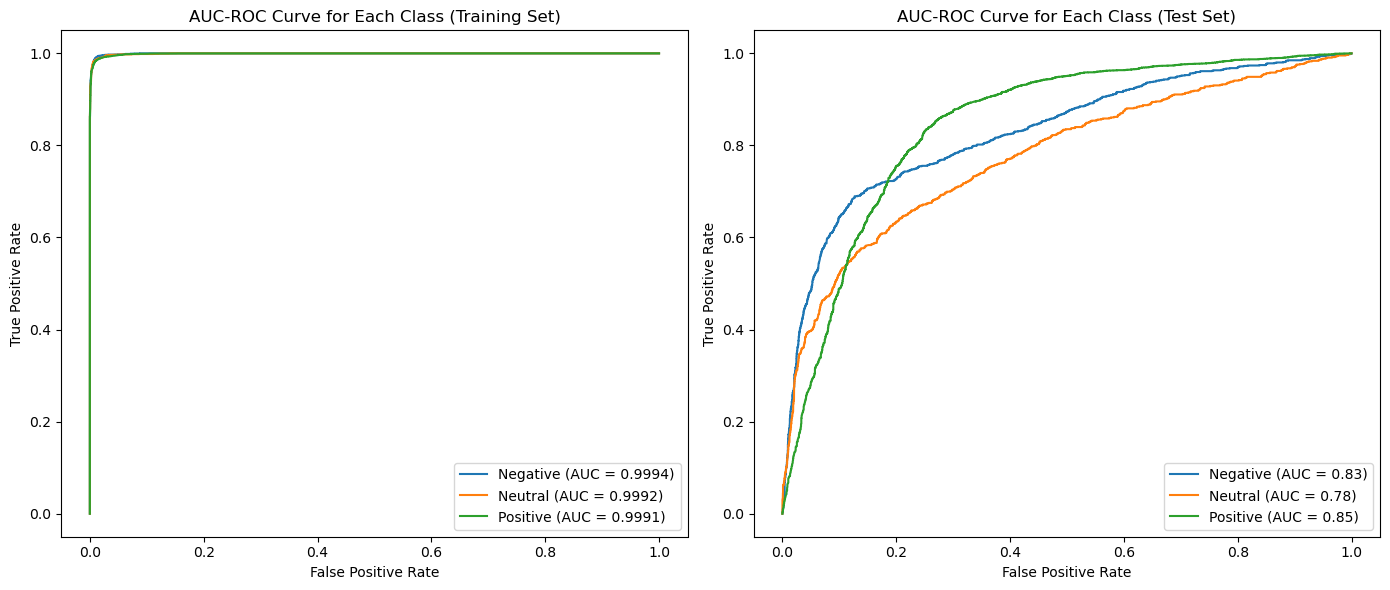

In [263]:
# Plot ROC curve for each class on training data
plt.figure(figsize=(14, 6))

# Training AUC-ROC
plt.subplot(1, 2, 1)
for i, class_name in enumerate(["Negative", "Neutral", "Positive"]):
    fpr, tpr, _ = roc_curve(y_train_binarized[:, i], y_train_pred_prob[:, i])
    plt.plot(fpr, tpr, label=f"{class_name} (AUC = {auc(fpr, tpr):.4f})")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("AUC-ROC Curve for Each Class (Training Set)")
plt.legend(loc="lower right")

# Testing AUC-ROC
plt.subplot(1, 2, 2)
for i, class_name in enumerate(["Negative", "Neutral", "Positive"]):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_test_pred_prob[:, i])
    plt.plot(fpr, tpr, label=f"{class_name} (AUC = {auc(fpr, tpr):.2f})")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("AUC-ROC Curve for Each Class (Test Set)")
plt.legend(loc="lower right")

plt.tight_layout()
plt.show()

In [264]:
# Ensure you have the original text data from the test set for interpretation
X_test_original_text = test_data['Tweet'].values  # Use the original 'Tweet' column

In [265]:
# Define the prediction function for LIME
def predict_probabilities(texts):
    # Tokenize and pad the texts
    sequences = tokenizer.texts_to_sequences(texts)
    padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')
    return model.predict(padded_sequences)

In [266]:
# Initialize LIME Text Explainer with class names
explainer = LimeTextExplainer(class_names=['Negative', 'Neutral', 'Positive'])

In [267]:
# Select a sample index from the test set to explain
sample_index = 0  # Change this index to analyze different samples
exp = explainer.explain_instance(X_test_original_text[sample_index], predict_probabilities, num_features=10)
# Display the explanation in the notebook
exp.show_in_notebook(text=True)

157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step


In [270]:
# Select a sample index from the test set to explain
sample_index = 15  # Change this index to analyze different samples
exp = explainer.explain_instance(X_test_original_text[sample_index], predict_probabilities, num_features=10)
# Display the explanation in the notebook
exp.show_in_notebook(text=True)

157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step


In [271]:
# Select a sample index from the test set to explain
sample_index = 26  # Change this index to analyze different samples
exp = explainer.explain_instance(X_test_original_text[sample_index], predict_probabilities, num_features=10)
# Display the explanation in the notebook
exp.show_in_notebook(text=True)

157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step


In [272]:
# Select a sample index from the test set to explain
sample_index = 50  # Change this index to analyze different samples
exp = explainer.explain_instance(X_test_original_text[sample_index], predict_probabilities, num_features=10)
# Display the explanation in the notebook
exp.show_in_notebook(text=True)

157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step


In [273]:
# Select a sample index from the test set to explain
sample_index = 76  # Change this index to analyze different samples
exp = explainer.explain_instance(X_test_original_text[sample_index], predict_probabilities, num_features=10)
# Display the explanation in the notebook
exp.show_in_notebook(text=True)

157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step


# Hyper Parameter Tunning:

* Increased Dropout Rate: Set dropout_rate to 0.6 in Dropout layers to reduce overfitting by preventing the model from becoming too dependent on any single feature.
* L2 Regularization: Added kernel_regularizer=l2(0.01) to the LSTM and Dense layers to penalize large weights, which helps improve generalization.
* Early Stopping: Included an EarlyStopping callback with monitor='val_loss' and patience=3, which will stop training if the validation loss doesn’t improve for 3 consecutive epochs. The restore_best_weights=True option ensures the model reverts to the weights from the epoch with the best validation loss.

In [284]:
# Define model parameters
embedding_dim = 50
lstm_units = 32
dropout_rate = 0.6  # Increased dropout rate from 0.5 to 0.6
vocab_size = 10000
max_length = 24

In [285]:
# Build the model with L2 regularization and increased dropout
model = Sequential([
    Input(shape=(max_length,)),
    Embedding(vocab_size, embedding_dim),
    Bidirectional(LSTM(lstm_units, return_sequences=True, kernel_regularizer=l2(0.01))),  # Add L2 regularization
    Dropout(dropout_rate),
    Bidirectional(LSTM(lstm_units, kernel_regularizer=l2(0.01))),  # Add L2 regularization
    Dense(3, activation='softmax', kernel_regularizer=l2(0.01))  # Add L2 regularization to the output layer
])

In [286]:
# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [287]:
# Set up early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [288]:
# Train the model with early stopping
history = model.fit(
    X_train_padded, y_train,
    epochs=20,  # Set a higher epoch count to allow early stopping to intervene
    batch_size=32,
    validation_data=(X_test_padded, y_test),
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 97s 115ms/step - accuracy: 0.6904 - loss: 1.6134 - val_accuracy: 0.7657 - val_loss: 0.6611
Epoch 2/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 83s 111ms/step - accuracy: 0.8011 - loss: 0.5846 - val_accuracy: 0.7843 - val_loss: 0.6260
Epoch 3/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 84s 111ms/step - accuracy: 0.8377 - loss: 0.5039 - val_accuracy: 0.7827 - val_loss: 0.6382
Epoch 4/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 71s 95ms/step - accuracy: 0.8526 - loss: 0.4715 - val_accuracy: 0.7892 - val_loss: 0.6863
Epoch 5/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 53s 70ms/step - accuracy: 0.8811 - loss: 0.3931 - val_accuracy: 0.7713 - val_loss: 0.6894


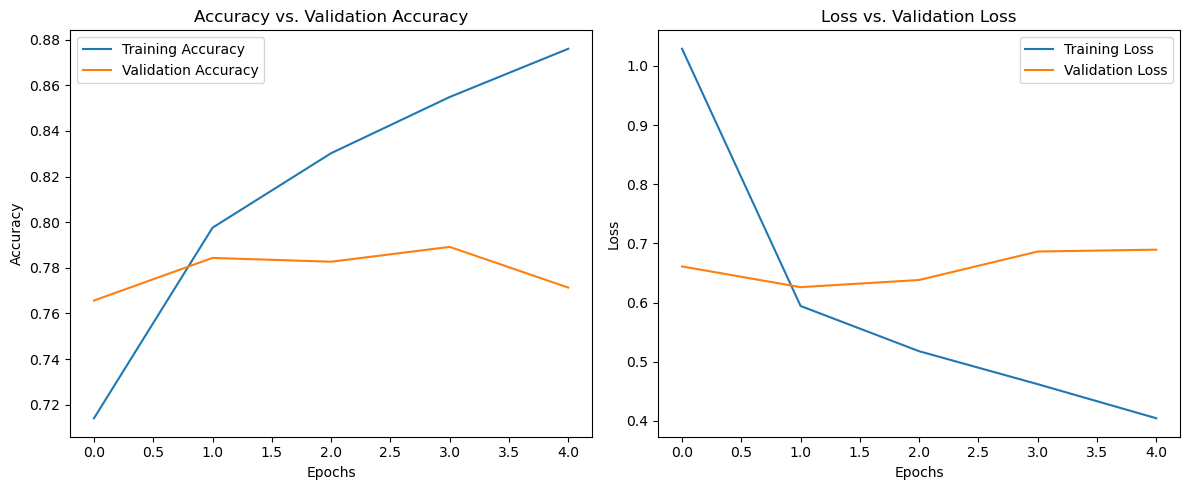

In [289]:
# Plot Accuracy vs. Validation Accuracy
plt.figure(figsize=(12, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Validation Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs. Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [290]:
# Evaluate on Training Data
y_train_pred_prob = model.predict(X_train_padded)
y_train_pred = np.argmax(y_train_pred_prob, axis=1)
train_conf_matrix = confusion_matrix(y_train, y_train_pred)
f1_train = f1_score(y_train, y_train_pred, average=None, labels=[2, 1, 0])  # F1 scores for Positive, Neutral, Negative
train_auc = roc_auc_score(pd.get_dummies(y_train), y_train_pred_prob, average='macro', multi_class='ovo')
train_accuracy = accuracy_score(y_train, y_train_pred)

750/750 ━━━━━━━━━━━━━━━━━━━━ 15s 20ms/step


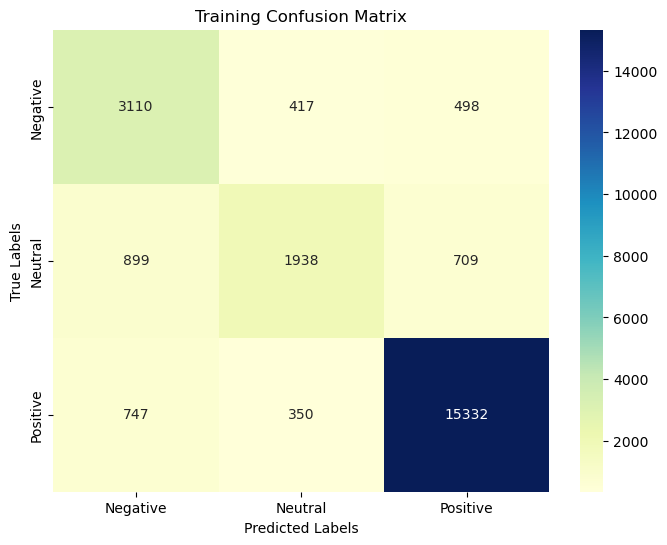

In [291]:
# Calculate the confusion matrix for the training set
train_conf_matrix = confusion_matrix(y_train, y_train_pred)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(train_conf_matrix, annot=True, fmt='d', cmap='YlGnBu', cbar=True, 
            xticklabels=["Negative", "Neutral", "Positive"], 
            yticklabels=["Negative", "Neutral", "Positive"])

plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Training Confusion Matrix")
plt.show()

In [292]:
# Evaluate on Testing Data
y_test_pred_prob = model.predict(X_test_padded)
y_test_pred = np.argmax(y_test_pred_prob, axis=1)
test_conf_matrix = confusion_matrix(y_test, y_test_pred)
f1_test = f1_score(y_test, y_test_pred, average=None, labels=[2, 1, 0])  # F1 scores for Positive, Neutral, Negative
test_auc = roc_auc_score(pd.get_dummies(y_test), y_test_pred_prob, average='macro', multi_class='ovo')
test_accuracy = accuracy_score(y_test, y_test_pred)

188/188 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step


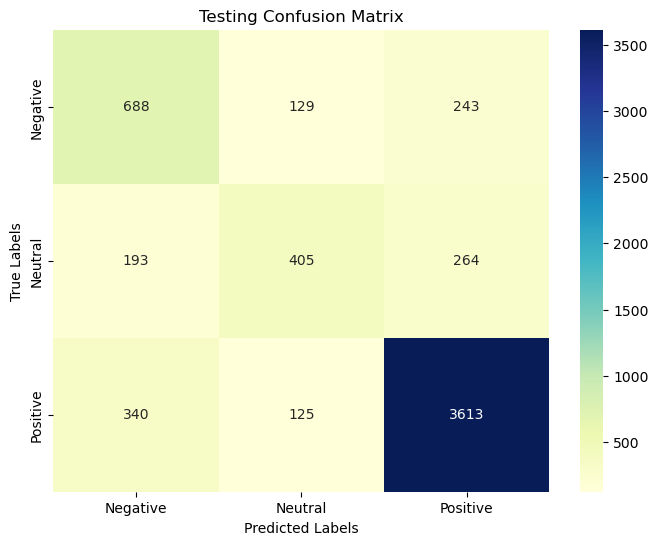

In [293]:
# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)

# Plot the confusion matrix as a heatmap with colors
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='YlGnBu', cbar=True, 
            xticklabels=["Negative", "Neutral", "Positive"], 
            yticklabels=["Negative", "Neutral", "Positive"])

plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Testing Confusion Matrix")
plt.show()

In [294]:
from sklearn.metrics import classification_report

# Training Data Classification Report
print("Training Classification Report:")
print(classification_report(y_train, y_train_pred, target_names=["Negative", "Neutral", "Positive"]))

Training Classification Report:
              precision    recall  f1-score   support

    Negative       0.65      0.77      0.71      4025
     Neutral       0.72      0.55      0.62      3546
    Positive       0.93      0.93      0.93     16429

    accuracy                           0.85     24000
   macro avg       0.77      0.75      0.75     24000
weighted avg       0.85      0.85      0.85     24000



In [295]:
# Testing Data Classification Report
print("\nTesting Classification Report:")
print(classification_report(y_test, y_test_pred, target_names=["Negative", "Neutral", "Positive"]))


Testing Classification Report:
              precision    recall  f1-score   support

    Negative       0.56      0.65      0.60      1060
     Neutral       0.61      0.47      0.53       862
    Positive       0.88      0.89      0.88      4078

    accuracy                           0.78      6000
   macro avg       0.68      0.67      0.67      6000
weighted avg       0.78      0.78      0.78      6000



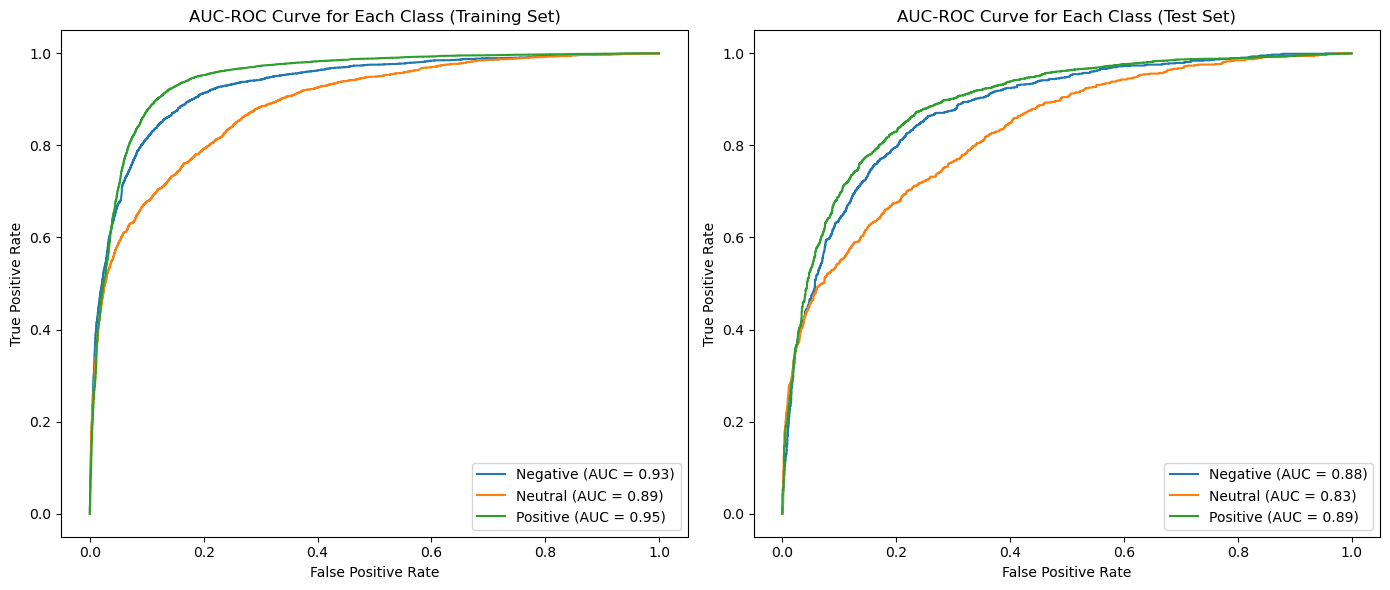

In [296]:
# Binarize the output for multi-class ROC (one-vs-rest approach)
y_train_binarized = label_binarize(y_train, classes=[0, 1, 2])  # Assuming 0: Negative, 1: Neutral, 2: Positive
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2])

# Plot ROC curve for each class on training data
plt.figure(figsize=(14, 6))

# Training AUC-ROC
plt.subplot(1, 2, 1)
for i, class_name in enumerate(["Negative", "Neutral", "Positive"]):
    fpr, tpr, _ = roc_curve(y_train_binarized[:, i], y_train_pred_prob[:, i])
    plt.plot(fpr, tpr, label=f"{class_name} (AUC = {auc(fpr, tpr):.2f})")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("AUC-ROC Curve for Each Class (Training Set)")
plt.legend(loc="lower right")

# Testing AUC-ROC
plt.subplot(1, 2, 2)
for i, class_name in enumerate(["Negative", "Neutral", "Positive"]):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_test_pred_prob[:, i])
    plt.plot(fpr, tpr, label=f"{class_name} (AUC = {auc(fpr, tpr):.2f})")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("AUC-ROC Curve for Each Class (Test Set)")
plt.legend(loc="lower right")

plt.tight_layout()
plt.show()

## Round - 2

* max_length = 32 
* vocab_size = 10000

In [302]:
# Set model parameters based on your analysis
embedding_dim = 100
lstm_units = 32
dropout_rate = 0.7  # Increased dropout rate to reduce overfitting
vocab_size = 10000  # Reduced vocabulary size for better generalization
max_length = 24  # Based on your analysis

In [303]:
# Tokenizer with reduced vocabulary size
tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train_text)  # Fit tokenizer only on training data
X_train_padded = pad_sequences(tokenizer.texts_to_sequences(X_train_text), maxlen=max_length, padding='post')
X_test_padded = pad_sequences(tokenizer.texts_to_sequences(X_test_text), maxlen=max_length, padding='post')

In [304]:
# Model Definition
model = Sequential([
    Input(shape=(max_length,)),
    Embedding(vocab_size, embedding_dim),
    Bidirectional(LSTM(lstm_units, return_sequences=True, kernel_regularizer=l2(0.001))),  # Added L2 regularization
    Dropout(dropout_rate),
    Bidirectional(LSTM(lstm_units, kernel_regularizer=l2(0.001))),  # Added L2 regularization
    Dense(3, activation='softmax', kernel_regularizer=l2(0.001))  # Added L2 regularization
])

In [305]:
# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [306]:
from sklearn.utils.class_weight import compute_class_weight

# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

In [307]:
class_weights = dict(enumerate(class_weights))
print("Class Weights:", class_weights)

Class Weights: {0: 1.9875776397515528, 1: 2.2560631697687534, 2: 0.48694381885689936}


In [308]:
# Set up early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Model Training with new parameters
history = model.fit(
    X_train_padded, y_train,
    epochs=20,  # Allow more epochs for early stopping to kick in
    batch_size=128,
    validation_data=(X_test_padded, y_test),
    class_weight=class_weights,  # Apply class weights
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 18s 60ms/step - accuracy: 0.4267 - loss: 1.2410 - val_accuracy: 0.7002 - val_loss: 0.8651
Epoch 2/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 9s 48ms/step - accuracy: 0.7899 - loss: 0.6734 - val_accuracy: 0.7583 - val_loss: 0.6871
Epoch 3/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - accuracy: 0.8457 - loss: 0.5120 - val_accuracy: 0.7060 - val_loss: 0.8181
Epoch 4/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - accuracy: 0.8733 - loss: 0.4151 - val_accuracy: 0.7658 - val_loss: 0.6892
Epoch 5/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - accuracy: 0.9025 - loss: 0.3347 - val_accuracy: 0.7330 - val_loss: 0.8286


## Round -3

In [325]:
# Set model parameters based on your analysis
embedding_dim = 50
lstm_units = 64
dropout_rate = 0.5  # Increased dropout rate to reduce overfitting
vocab_size = 10000  # Reduced vocabulary size for better generalization
max_length = 24  # Based on your analysis

In [326]:
# Tokenizer with reduced vocabulary size
tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train_text)  # Fit tokenizer only on training data
X_train_padded = pad_sequences(tokenizer.texts_to_sequences(X_train_text), maxlen=max_length, padding='post')
X_test_padded = pad_sequences(tokenizer.texts_to_sequences(X_test_text), maxlen=max_length, padding='post')

In [327]:
# Model Definition
model = Sequential([
    Input(shape=(max_length,)),
    Embedding(vocab_size, embedding_dim),
    Bidirectional(LSTM(lstm_units, return_sequences=True, kernel_regularizer=l2(0.01))),  # Added L2 regularization
    Dropout(dropout_rate),
    Bidirectional(LSTM(lstm_units, kernel_regularizer=l2(0.01))),  # Added L2 regularization
    Dense(3, activation='softmax', kernel_regularizer=l2(0.01))  # Added L2 regularization
])

In [328]:
# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [329]:
#from imblearn.over_sampling import RandomOverSampler

# Oversample training data
#oversampler = RandomOverSampler(random_state=42)
#X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train_padded, y_train)

In [330]:
# Set up early stopping
#early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Model Training with new parameters
#history = model.fit(
#    X_train_resampled, y_train_resampled,
#    epochs=20,  # Allow more epochs for early stopping to kick in
#    batch_size=128,
#    validation_data=(X_test_padded, y_test),
#    callbacks=[early_stopping],
#    verbose=1
#)

In [333]:
from imblearn.keras import BalancedBatchGenerator
from imblearn.under_sampling import RandomUnderSampler

# Define the batch generator without unpacking into two variables
training_generator = BalancedBatchGenerator(
    X_train_padded, y_train,
    sampler=RandomUnderSampler(),
    batch_size=32,
    random_state=42
)

# Fit the model using the balanced batch generator
history = model.fit(
    training_generator,
    epochs=10,
    validation_data=(X_test_padded, y_test),
          callbacks=[early_stopping],
    verbose=1
)

Epoch 1/10


C:\Users\Dell\AppData\Roaming\Python\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


332/332 ━━━━━━━━━━━━━━━━━━━━ 18s 36ms/step - accuracy: 0.4241 - loss: 2.7047 - val_accuracy: 0.7058 - val_loss: 0.9836
Epoch 2/10
332/332 ━━━━━━━━━━━━━━━━━━━━ 12s 35ms/step - accuracy: 0.5127 - loss: 0.9432 - val_accuracy: 0.3093 - val_loss: 1.1291
Epoch 3/10
332/332 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - accuracy: 0.5970 - loss: 0.8623 - val_accuracy: 0.6593 - val_loss: 0.9596
Epoch 4/10
332/332 ━━━━━━━━━━━━━━━━━━━━ 12s 35ms/step - accuracy: 0.7133 - loss: 0.7440 - val_accuracy: 0.6420 - val_loss: 1.0128
Epoch 5/10
332/332 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - accuracy: 0.8015 - loss: 0.5746 - val_accuracy: 0.6677 - val_loss: 0.9615
Epoch 6/10
332/332 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - accuracy: 0.8510 - loss: 0.4643 - val_accuracy: 0.6745 - val_loss: 1.0186
